# Master AQ Interview Notebook #
### Date : 2019-05-13 ###
### Analyst : Greg ###
**Description:** Master notebook which loads Partcipant's AQ Data, ACT Data, and EPA data. Showcase of common exercises and syntax done in practice interviews that can be used in interviews.


# Import External Libraries #

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
from bin import calendar_heatmap as cal
import datetime

# Define Dictionary and Functions #

In [97]:
def getMonitorLocationsFromDeployment(dep):
    return{
        'deployment_001': ['living room','bedroom','outside'],
        'deployment_003': ['bedroom','downstairs','outside'],
        'deployment_007': ['outside','sons room','kitchen'],
        'deployment_008': ['bedroom','kitchen','downstairs','backyard'],
        'deployment_009': ['bedroom','front room','outside'],
        'deployment_012': ['bedroom','living room','front room','back yard','front yard', 'downstairs'],
    }[dep]

def getDeploymentFromParticipantID(pid):
    return{
    'P2':'deployment_001',
    'P1':'deployment_003',
    'P3':'deployment_008',
    'P4':'deployment_009',
    'P5':'deployment_012',
    'P6':'deployment_007',
    }[pid]

def loadParticipantData(pid):
    '''
    Load Participants CSV Files and Format index to MST time.
    Participants range from P1 - P6.
    Log Types:
        spikes: Detected Spikes in participants home
        notifications: Sent Notifications to participants
        annotations: Received Annotations from participants
        pm: Read Out of the Particle Matter(?) from the digizter from the particle detector.
    Infiles:
        Participant_data/<Participant>_<log_type>_log.csv
    Out DataFrames:
        spikes: Detected Spikes in participants home
        notifications: Sent Notifications to participants
        annotations: Received Annotations from participants
        pm: 
    '''
    # Path to Participant Data in current dir #
    in_dir = 'Participant_data/'
    
    # In CSV File Types #
    log_types = ['spikes','notifications','annotations', 'pm']

    #Define infiles #
    infiles = [ in_dir+'{0}_{1}_log.csv'.format(pid,log_type) for log_type in log_types]
    
    # Load Participant's DataFrames # 
    spikes_df = pd.read_csv(infiles[0],skipinitialspace=True,encoding="ISO-8859-1",sep='\s*,\s*')
    notification_df = pd.read_csv(infiles[1],skipinitialspace=True,encoding="ISO-8859-1",sep=',')
    annotation_df = pd.read_csv(infiles[2],skipinitialspace=True,encoding="ISO-8859-1",sep='\s*,\s*')
    pm_df = pd.read_csv(infiles[3],skipinitialspace=True,encoding="ISO-8859-1",sep='\s*,\s*')
    
    # Format Event Time as Datetime #
    # Issue with datetime and timezone. Removing -HH:MM from Time info and then convert to datetime
    
    # Spike DF #
    spikes_df['event_time'] = pd.to_datetime(spikes_df['event_time'])
    spikes_df['event_time_mst'] = pd.to_datetime(spikes_df['event_time_mst'].replace(regex=r'-\d+:\d+',value=''))

    # Notification DF #
    notification_df['event_time'] = pd.to_datetime(notification_df['event_time'])
    notification_df['event_time_mst'] = pd.to_datetime(notification_df['event_time_mst'].replace(regex=r'-\d+:\d+',value=''))
    
    # Annotation DF #
    annotation_df['event_time'] = pd.to_datetime(annotation_df['event_time'])
    annotation_df['event_time_mst'] = pd.to_datetime(annotation_df['event_time_mst'].replace(regex=r'-\d+:\d+',value=''))
    annotation_df['insert_time'] = pd.to_datetime(annotation_df['insert_time'])
    annotation_df['insert_time_mst'] = pd.to_datetime(annotation_df['insert_time_mst'].replace(regex=r'-\d+:\d+',value=''))
    
    # PM DF #
    pm_df['time'] = pd.to_datetime(pm_df['time'].replace(regex=r'-\d+:\d+',value=''))
    
    # Set MST Time as Index of DataFrame #
    spikes_df.index = spikes_df['event_time_mst']
    notification_df.index = notification_df['event_time_mst']
    annotation_df.index = annotation_df['event_time_mst']
    pm_df.index = pd.to_datetime(pm_df['time'])
            
    # Remove Event Time Column #
    # Ignore since data in column is used later
    # del spikes_df['event_time'], notification_df['event_time'], annotation_df['event_time'], pm_df['time']
    
    return spikes_df, notification_df, annotation_df, pm_df

def pm2UGMC(pm):
    '''
    Convert PM to micrograms per cubic meters.
    '''
    scale_factor = .006
    
    return pm * scale_factor

def ugmc2AQI(ugmc,type):
    '''
    For USA Conversion Source, see https://en.wikipedia.org/wiki/Air_quality_index#United_States
    '''
    
    index_high, index_low, C_high, C_low = 50, 0, 12.0, 0.0
    
    if type == 'PM25':
        if  (12.1 > ugmc ) & (ugmc >= 0.0) : index_high, index_low, C_high, C_low = 50, 0, 12.0, 0.0
        elif (35.5 > ugmc ) & (ugmc >= 12.1): index_high, index_low, C_high, C_low = 100, 51, 35.4, 12.1
        elif (55.5 > ugmc ) & (ugmc >= 35.5): index_high, index_low, C_high, C_low = 150, 101, 55.4, 35.5
        elif (150.5 > ugmc ) & (ugmc >= 55.5): index_high, index_low, C_high, C_low = 200, 151, 150.4, 55.5
        elif (250.5 > ugmc ) & (ugmc >= 150.5): index_high, index_low, C_high, C_low = 300, 201, 250.4, 150.5
        elif (350.5 > ugmc ) & (ugmc >= 250.5): index_high, index_low, C_high, C_low = 400, 301, 350.4, 250.5
        elif (500.4 > ugmc ) & (ugmc >= 350.5): index_high, index_low, C_high, C_low = 500, 401, 500.4, 350.5
            
    elif type == 'PM10':
        if  (55 > ugmc ) & (ugmc >= 0) : index_high, index_low, C_high, C_low = 54, 0, 12.0, 0.0
        elif (155 > ugmc ) & (ugmc >= 55): index_high, index_low, C_high, C_low = 154, 55, 35.4, 12.1
        elif (255 > ugmc ) & (ugmc >= 155): index_high, index_low, C_high, C_low = 254, 155, 55.4, 35.5
        elif (355 > ugmc ) & (ugmc >= 255): index_high, index_low, C_high, C_low = 354, 255, 150.4, 55.5
        elif (425 > ugmc ) & (ugmc >= 355): index_high, index_low, C_high, C_low = 424, 355, 250.4, 150.5
        elif (505 > ugmc ) & (ugmc >= 425): index_high, index_low, C_high, C_low = 504, 425, 350.4, 250.5
        elif (604 > ugmc ) & (ugmc >= 505): index_high, index_low, C_high, C_low = 604, 505, 500.4, 350.5
            
    aqi_index = (index_high -  index_low)/(C_high - C_low)*(ugmc - C_low) + index_low
    
    return aqi_index

def aqiCategory(aqi_value):
    '''
    Convert AQI value to Category
    '''
    if aqi_value < 50: return 'Good'
    elif (aqi_value > 51) & (aqi_value < 100): return 'Moderate'
    elif (aqi_value > 101) & (aqi_value < 150): return 'Unhealthy for Sensitive Groups'
    elif (aqi_value > 151) & (aqi_value < 200): return 'Unhealthy'
    elif (aqi_value > 201) & (aqi_value < 300): return 'Very Unhealthy'
    elif (aqi_value > 301) & (aqi_value < 500): return 'Hazardous'
    
def aqiColor(aqi_value):
    '''
    Convert AQI value to EPA Color
    '''
    if aqi_value < 50: return 'Green'
    elif (aqi_value > 51) & (aqi_value < 100): return 'Yellow'
    elif (aqi_value > 101) & (aqi_value < 150): return 'Orange'
    elif (aqi_value > 151) & (aqi_value < 200): return 'Red'
    elif (aqi_value > 201) & (aqi_value < 300): return 'Purple'
    elif (aqi_value > 301) & (aqi_value < 500): return 'Maroon'

def plotSpike(annot_df, pm_df, daily_eat_df, event_index):
    '''
    Plot Spike of Participants Detectors at all 3 locations given:
    annot_df: DataFrame of Spikes from Participant with Annotations
    pm_df : Data From deployed detectors
    event_index: Index of Spike in annot_df to search for and plot    
    '''
    
    locations = pm_df['location'].unique()
    
    # Select Event #
    select_event_time = annot_df['event_time_mst'][event_index]
    insert_time = annot_df['insert_time_mst'][event_index]
    event_class = annot_df['class'][event_index]
    event_cause = annot_df['annotation_text'][event_index]

    record_event = np.abs((select_event_time - insert_time).total_seconds())
    print('======= Event Info =======')
    print('Event Time:\t{0}'.format(annot_df.index[event_index]))
    print('Event Class:\t{0}'.format(event_class))
    print('Event Cause:\t\'{0}\''.format(event_cause))
    print('Event Recorded:\t{0}'.format(insert_time))
    print('')
    print('Time Elapsed til recorded:\t{0} seconds'.format(record_event))
    print('=========================')

    # Find Closest Time #
    diff_time =  pm_df['time'] - select_event_time
    closest_time = diff_time.dt.total_seconds().abs().idxmin()
    closest_time_sec = diff_time.dt.total_seconds().abs().min()
    print('Found Closest Time at {0} (within {1} seconds)'.format(closest_time, closest_time_sec))

    # Find Daily eAT Info #
    spike_date = select_event_time.date()
    print(str(spike_date))
    match_daily_eat_df = daily_eat_df[daily_eat_df.index.date == spike_date]
#     match_daily_eat_df = daily_eat_df[pd.to_datetime(daily_eat_df['Family study ID, or deployment ID']) == spike_date]

    # Did Not Find Event #
    t_tol = 100
    if closest_time_sec > t_tol :
        print('')
        print('No Event Found Within {0} seconds...'.format(t_tol))
        print('')
        
    else :
        
        # Define Window Size in seconds #
        window = 60 * 60
        min_t = closest_time - datetime.timedelta(0,window)
        if window < record_event : max_t = closest_time + datetime.timedelta(0,record_event)
        else : max_t = closest_time + datetime.timedelta(0,window)

        df = pm_df[(pm_df.index > min_t) & (pm_df.index < max_t)]
        # print(df)
        print('')
        print('Found Event Between {0} - {1}'.format(min_t, max_t))
        print('')

        plt.figure(figsize=(16,7))
        for location in locations:
            plt.plot(df.index[df['location'] == location], df['value'][df['location'] == location], label='{0} Detector'.format(location))
        plt.axvline(x=select_event_time, linestyle='--', color='orange', label='Event Start')
        plt.axvline(x=insert_time, linestyle='--', color='purple', label='Event Cause Recorded as \'{0}\''.format(event_cause))
        plt.title('Event caused by {0}'.format(event_class))
        plt.legend()
        plt.show()
        
        # Print Non NAN daily eAT info #
        if len(match_daily_eat_df) > 0:
            for column in match_daily_eat_df.dropna(axis=1,how='all') :
#                 display(match_daily_eat_df[column])
                print('{0} : {1}'.format(column,match_daily_eat_df[column].values))
        
def rollAQPlot(df, freq, rolling_window, location=None):
    '''
    Plot of DataFrame, df, split by location and averaged over time period, freq.
    A rolling average is applied with n number of freq, rolling_window.
    '''
    
    # Select Location #
    if location != None :
           df = df[df['location'] == location]
        
    # Pivot Table on Location #
    loc_df = df.groupby([df.index.to_period(freq), 'location']).value.agg(['mean','max','min','std']).unstack(level=1)
    #display(loc_df.head())

    # Rolling Average #
    roll = loc_df['mean'].rolling(rolling_window, min_periods=1).mean()
    roll = roll.fillna(method='bfill')
    roll = roll.fillna(method='ffill')
    
    # Plot Aggregate Data #
    ax2 = roll.plot(figsize=(16,9), linestyle='--', color=['Red','Blue','Green'], alpha=.5)
    # loc_df['mean'].plot(ax=ax2, color=['Red','Blue','Green'])
    
    # Labels #
    labels = [ 'rolling average for {0}'.format(i) for i in list(roll.columns)] + list(loc_df['mean'].columns)
    ax2.legend(labels)

    # Plot Info #
    plt.title('PM Aggregated over {0} by Detector Location'.format(freq))
    plt.ylabel('PM')
    plt.xlabel('Date')
    
def loadEPAData():
    '''
    Load EPA CSV files with EPA Air Quality Data of SLC
    '''
    parent = 'EPA_data/'
    
    # Load SLC AQI Data #
    airnow_aqi_2017 = parent + 'airnow_slc_2017_data.csv'
    airnow_aqi_2018 = parent + 'airnow_slc_2018_data.csv'

    aqi_2017_df = pd.read_csv(airnow_aqi_2017)
    aqi_2018_df = pd.read_csv(airnow_aqi_2018)

    aqi_2017_df.index = pd.to_datetime(aqi_2017_df['Date'])
    aqi_2018_df.index = pd.to_datetime(aqi_2018_df['Date'])

    epa_aqi_df = pd.concat([aqi_2017_df, aqi_2018_df])

    # Replace '.' in missing data :
    epa_aqi_df = epa_aqi_df.replace('.', np.nan)

    epa_aqi_df['PM10 AQI Value'] = pd.to_numeric(epa_aqi_df['PM10 AQI Value'])
    epa_aqi_df['PM2.5 AQI Value'] = pd.to_numeric(epa_aqi_df['PM2.5 AQI Value'])
    
    return epa_aqi_df

def getPID(family_id):
    return {
        1070 : 'P1',
        1020 : 'P2',
        1060 : 'P3',
        1030 : 'P4',
        1090 : 'P5',
        1080 : 'P6'
}.get(family_id, 'unknown PID')

def loadeATDatabypid(PID):
    '''
    Load Weekly eAT Data of participant id.
    '''
    
    # Load Weekly and Daily CSV #
    parent = 'eAT_data/formatted_csv_files/'
    weekly_eat_df = pd.read_csv(parent + "EAT_weekly_results.csv",encoding = "ISO-8859-1")
    daily_eat_df = pd.read_csv(parent + "eat_daily_results.csv",encoding = "ISO-8859-1")
    
    # Add PID Info #
    weekly_eat_df['pid'] = weekly_eat_df['Family study ID, or deployment ID'].apply(lambda row: getPID(row))
    daily_eat_df['pid'] = daily_eat_df['Family study ID, or deployment ID'].apply(lambda row: getPID(row))
    
    # Load Selected PID #
    P_weekly_eat_df = weekly_eat_df[['timestamp','answer_1','answer_2','answer_3','answer_4','answer_5','answer_sum']][weekly_eat_df['pid'] == PID]
    P_daily_eat_df = daily_eat_df[daily_eat_df['pid'] == PID]
    
    # Add Index #
    P_weekly_eat_df.index = pd.to_datetime(P_weekly_eat_df['timestamp'])
    P_daily_eat_df.index = pd.to_datetime(P_daily_eat_df['Time stamp daily eAT'])
    
    return P_weekly_eat_df, P_daily_eat_df

def loadeATDatabyeatpid(eAT_PID):
    '''
    Load Weekly eAT Data of participant by eat_pid.
    '''
    
    # Load Weekly and Daily CSV #
    parent = 'eAT_data/formatted_csv_files/'
    weekly_eat_df = pd.read_csv(parent + "EAT_weekly_results.csv",encoding = "ISO-8859-1")
    daily_eat_df = pd.read_csv(parent + "eat_daily_results.csv",encoding = "ISO-8859-1")
    
    # Add PID Info #
    weekly_eat_df['pid'] = weekly_eat_df['Family study ID, or deployment ID'].apply(lambda row: getPID(row))
    daily_eat_df['pid'] = daily_eat_df['Family study ID, or deployment ID'].apply(lambda row: getPID(row))
    
    # Load Selected eat PID #
    P_weekly_eat_df = weekly_eat_df[['timestamp','answer_1','answer_2','answer_3','answer_4','answer_5','answer_sum']][weekly_eat_df['eat_pid'] == eAT_PID]
    P_daily_eat_df = daily_eat_df[daily_eat_df['eat_pid'] == eAT_PID]
    
    # Add Index #
    P_weekly_eat_df.index = pd.to_datetime(P_weekly_eat_df['timestamp'])
    P_daily_eat_df.index = pd.to_datetime(P_daily_eat_df['Time stamp daily eAT'])
    
    return P_weekly_eat_df, P_daily_eat_df

def loadWeatData():
    store = pd.HDFStore('weat.h5')
    master_weat_df = store.get('master_weat')
    store.close()
    
    return master_weat_df

# Load Example Participant Data #

In [10]:
spikes_df, not_df, annot_df, pm_df = loadParticipantData('P1')
# epa_aqi_df = loadEPAData()
weekly_eat_df, daily_eat_df  = loadeATDatabypid('P1')
# weat_df = loadWeatData()

/home/gfurlich/.local/lib/python3.6/site-packages/ipykernel_launcher.py:48: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/home/gfurlich/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/home/gfurlich/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


# Display Annotated Data DataFrame #

In [4]:
display(annot_df.head())

,annotation_source,annotation_text,class,event_time,insert_time,event_time_mst,insert_time_mst,year,month,hour,day_phase,weekday,week_phase,week number,season
event_time_mst,,,,,,,,,,,,,,,
2017-08-07 18:23:00,sms,Is this the prism study?,unknown,2017-08-08 00:23:00,2017-08-08 00:24:00,2017-08-07 18:23:00,2017-08-07 18:24:00,2017,August,18,evening,Monday,weekday,32,summer
2017-08-07 18:37:00,sms,Ok - I'm assuming you're the prism study. I am...,unknown,2017-08-08 00:37:00,2017-08-08 00:37:00,2017-08-07 18:37:00,2017-08-07 18:37:00,2017,August,18,evening,Monday,weekday,32,summer
2017-08-07 18:37:00,sms,the spike is them working again.,outside,2017-08-08 00:37:00,2017-08-08 00:37:00,2017-08-07 18:37:00,2017-08-07 18:37:00,2017,August,18,evening,Monday,weekday,32,summer
2017-08-08 15:23:00,sms,No idea. No one was home.,unknown,2017-08-08 21:23:00,2017-08-09 00:07:00,2017-08-08 15:23:00,2017-08-08 18:07:00,2017,August,15,afternoon,Tuesday,weekday,32,summer
2017-08-09 07:56:00,sms,The door opening,outside,2017-08-09 13:56:00,2017-08-09 14:10:00,2017-08-09 07:56:00,2017-08-09 08:10:00,2017,August,7,morning,Wednesday,weekday,32,summer


# Plot All AQ PM Values Data #

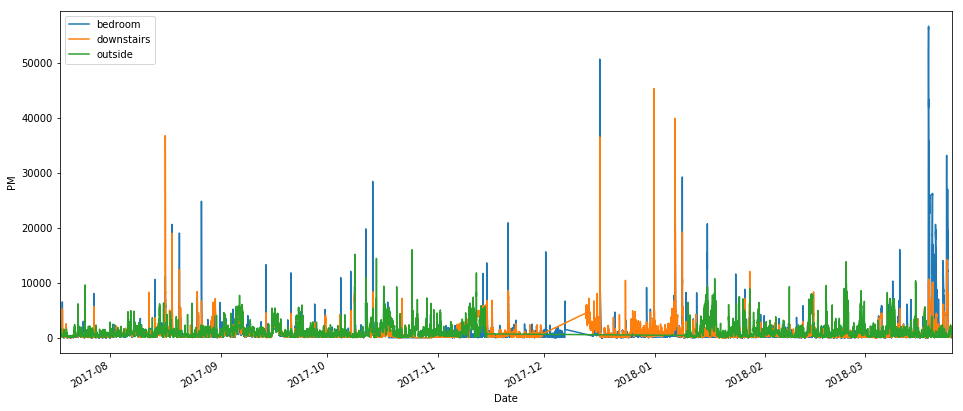

In [11]:
# plt.style.use('seaborn')
# %matplotlib inline
pm_df.groupby('location').value.plot(figsize=(16,7))
# pm_df[pm_df['month'] == 'November'].groupby('location').value.plot(figsize=(16,7))
plt.ylabel('PM')
plt.xlabel('Date')
plt.legend()

## Plot Month ##

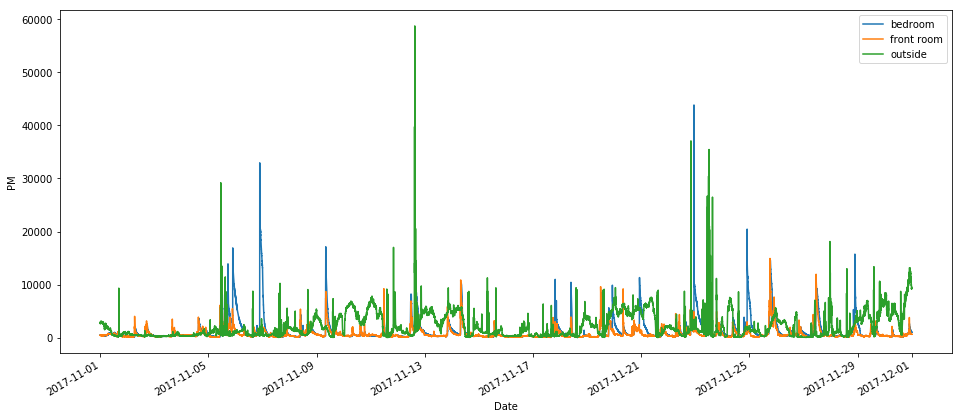

In [6]:
pm_df[pm_df['month'] == 'November'].groupby('location').value.plot(figsize=(16,7))
plt.ylabel('PM')
plt.xlabel('Date')
plt.legend()

## Plot Between 2 Dates ##

Text(0.5, 0, 'Date')

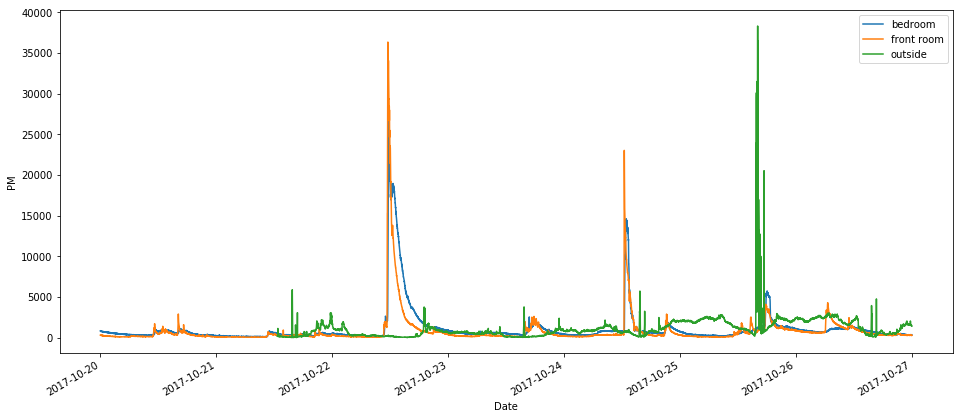

In [7]:
# Set min and max time #
min_t, max_t = datetime.datetime(2017,10,20), datetime.datetime(2017,10,27)
    
# Cut DataFrame Dates #
df = pm_df[(pm_df.index > min_t) & (pm_df.index < max_t)]

# Plot #
df.groupby('location').value.plot(figsize=(16,7))
plt.legend()
plt.ylabel('PM')
plt.xlabel('Date')

# eAT Data #
## Questions 1-5 ##

In [66]:
# Display daily eat info #
# display(daily_eat_df.head())
display(daily_eat_df[daily_eat_df.index.date == annot_df['event_time'][0].date()])
print(annot_df.iloc[0].event_time.date())

,"Family study ID, or deployment ID",Event Name,Repeat Instrument,Repeat Instance,eat_pid,Time stamp daily eAT,Person filling this out (relationship to the patient),In case relationship is other than self/parent,How would you rate your child's asthma control in the last 24 hours?,How often did you/your child use an albuterol or Xopenex inhaler or receive a nebulized treatment in the last 24 hours?,...,"In the last 24 hours, which of the following types of possible asthma triggers were you exposed to that affected (or could have affected) his/her asthma symptoms (check all that apply): Option Text - None of the above",Please check all of the following that have applied to you in the last 24 hours because of any asthma symptoms he/she had. The option text - I had difficulty sleeping,"Please check all of the following that have applied to you in the last 24 hours because of any asthma symptoms he/she had. The option text - I missed part or all of school, work, or other activities I typically do",Please check all of the following that have applied to you in the last 24 hours because of any asthma symptoms he/she had. The option text - I had to stay indoors more than usual,"Please check all of the following that have applied to you in the last 24 hours because of any asthma symptoms he/she had. The option text - I had to get urgent or emergency medical care (e.g., at my doctor's office, at an emergency room, at an urgent ca",Please check all of the following that have applied to you in the last 24 hours because of any asthma symptoms he/she had. The option text - None of the above,"Did you spend time outside his/her usual living area in the last 24 hours (e.g., on vacation)?","If 'answer_5' = 1, then this field holds the information where the time was spent.",Complete?,pid
Time stamp daily eAT,,,,,,,,,,,,,,,,,,,,,
2017-07-02 19:02:00,1070,Home (Arm 1: Family),Eat Daily,109,869,7/2/2017 19:02,self,NaN,4,1,...,NaN,NaN,NaN,NaN,NaN,1.0,2,NaN,Incomplete,P1


2017-07-02


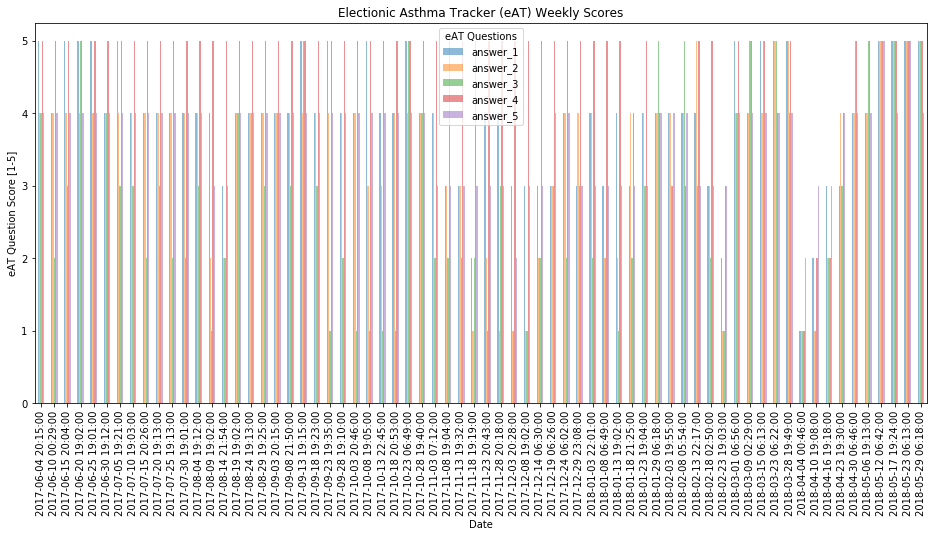

In [8]:
# Plot eAT #
# min_t, max_t = datetime.datetime(2017,9,1), datetime.datetime(2017,12,31)

# t_eat_df = eat_df[(eat_df.index > min_t) & (eat_df.index < max_t)]

ax1 = weekly_eat_df.drop('answer_sum', axis=1).plot(figsize=(16,7), alpha=.5, kind='bar')
ax1.set_ylabel('eAT Question Score [1-5]')
ax1.set_xlabel('Date')
ax1.set_title('Electionic Asthma Tracker (eAT) Weekly Scores')
# ax1.set_ylim([0,6])
plt.legend(title='eAT Questions')
plt.show()


## Question Sum ##

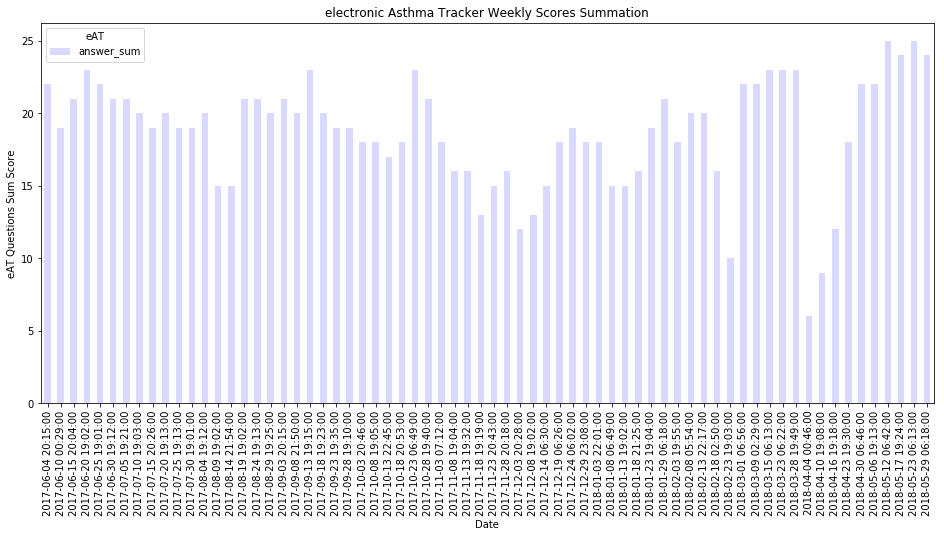

In [9]:
ax1 = weekly_eat_df['answer_sum'].plot(figsize=(16,7), alpha=.15, kind='bar', color='blue')
ax1.set_ylabel('eAT Questions Sum Score')
ax1.set_xlabel('Date')
ax1.set_title('electronic Asthma Tracker Weekly Scores Summation')
plt.legend(title='eAT')
plt.show()

# Plot eAT vs PM Values #

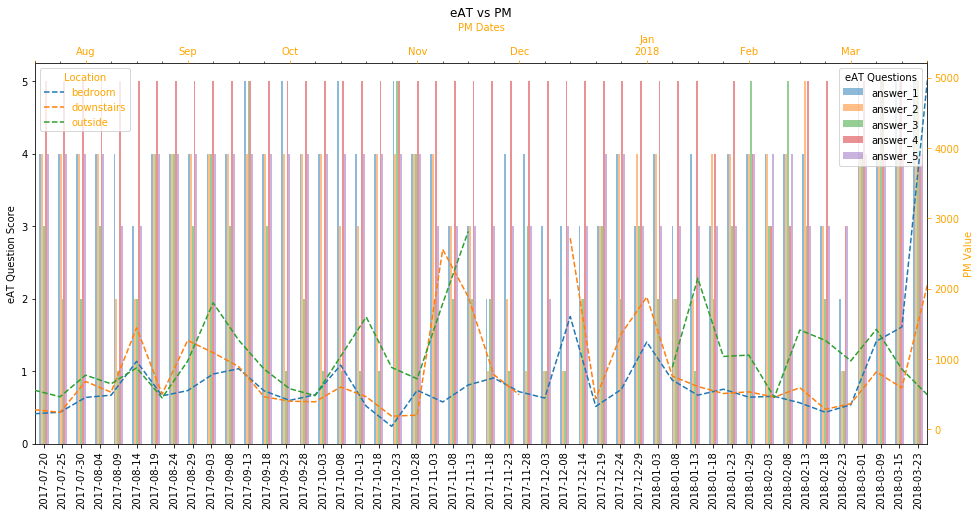

In [14]:
# Select over time Range #
# min_t, max_t = weekly_eat_df.index.min(), weekly_eat_df.index.max()
min_t, max_t = pm_df.index.min(), pm_df.index.max()

t_eat_df = weekly_eat_df[(weekly_eat_df.index > min_t) & (weekly_eat_df.index < max_t)]
t_pm_df = pm_df[(pm_df.index > min_t) & (pm_df.index < max_t)]

t_eat_df.index = t_eat_df.index.date

# Create Axes #
fig=plt.figure()
ax=fig.add_subplot(111, label="eAT")
ax2=fig.add_subplot(111, label="PM", frame_on=False)

t_eat_df.drop('answer_sum', axis=1).plot(figsize=(16,7), ax=ax, alpha=.5, kind='bar')
loc_df = t_pm_df.groupby([t_pm_df.index.to_period('w'), 'location']).value.agg(['mean','max','min','std']).unstack(level=1)
loc_df['mean'].plot(figsize=(16,7), linestyle='--', ax=ax2 )

plt.title('eAT vs PM')
ax.set_ylabel('eAT Question Score')
ax.legend(title='eAT Questions',loc=1)

# Set Second Axis x ontop and y on left #
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('PM Dates', color='orange') 
ax2.set_ylabel('PM Value', color='orange')    
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors='orange')
ax2.tick_params(axis='y', colors='orange')

# Set Second Legend #
leg = ax2.legend(title='Location',loc=2)
leg.get_title().set_color('orange')
plt.setp(leg.get_texts(), color='orange')
ax2.set_xlim([t_pm_df.index.min(),t_pm_df.index.max()])
plt.show()

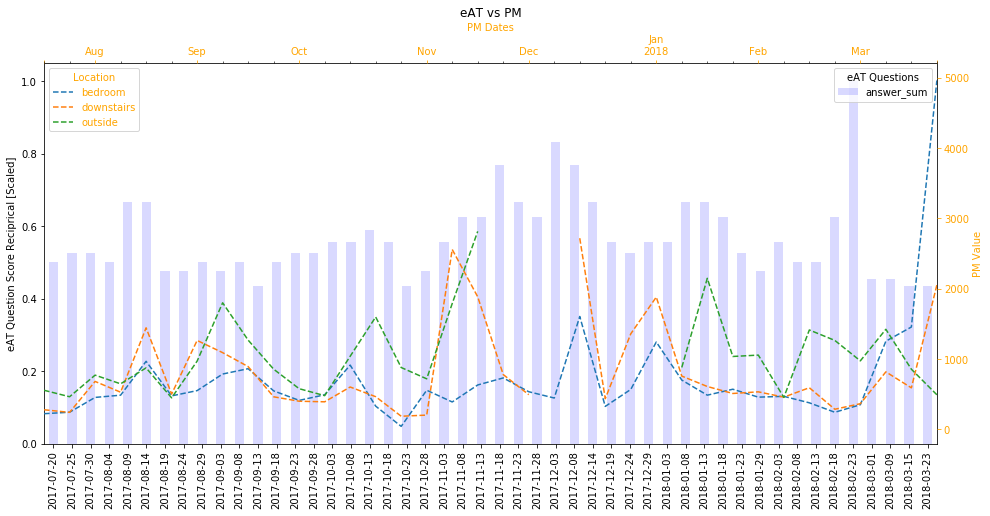

In [15]:
# Select over time Range #
# min_t, max_t = weekly_eat_df.index.min(), weekly_eat_df.index.max()
min_t, max_t = pm_df.index.min(), pm_df.index.max()

t_eat_df = weekly_eat_df[(weekly_eat_df.index > min_t) & (weekly_eat_df.index < max_t)]
t_pm_df = pm_df[(pm_df.index > min_t) & (pm_df.index < max_t)]

t_eat_df.index = t_eat_df.index.date

# Create Axes #
fig=plt.figure()
ax=fig.add_subplot(111, label="eAT")
ax2=fig.add_subplot(111, label="PM", frame_on=False)

# eAT Plot #
# t_eat_df['answer_sum'].plot(figsize=(16,7), ax=ax, alpha=.15, kind='bar', color='blue')

recip_eat_df =  1 / t_eat_df['answer_sum'] * t_eat_df['answer_sum'].min()
recip_eat_df.plot(figsize=(16,7), ax=ax, alpha=.15, kind='bar', color='blue')
ax.set_ylabel('eAT Question Score Reciprical [Scaled]')

plt.title('eAT vs PM')
# ax.set_ylabel('eAT Question Score')
ax.legend(title='eAT Questions',loc=1)

# PM Plot #
loc_df = t_pm_df.groupby([t_pm_df.index.to_period('w'), 'location']).value.agg(['mean','max','min','std']).unstack(level=1)
loc_df['mean'].plot(figsize=(16,7), linestyle='--', ax=ax2 )

# Set Second Axis x ontop and y on left #
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('PM Dates', color='orange') 
ax2.set_ylabel('PM Value', color='orange')    
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors='orange')
ax2.tick_params(axis='y', colors='orange')

# Set Second Legend #
leg = ax2.legend(title='Location',loc=2)
leg.get_title().set_color('orange')
plt.setp(leg.get_texts(), color='orange')
ax2.set_xlim([t_pm_df.index.min(),t_pm_df.index.max()])
plt.show()

# Find Spikes of Certain Class #

In [16]:
# Display annotated spikes class type #
print(annot_df['class'].unique())

['outside' 'smoke' 'dust' 'cooking' 'aerosol' 'unknown']


# Spike Class Bar Chart #

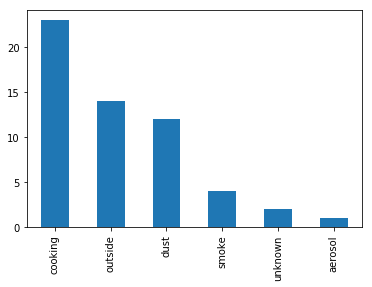

In [17]:
annot_df['class'].value_counts().plot(kind = 'bar')

# Print All Cooking Annotations #

In [54]:
cooking_df = annot_df[annot_df['class'] == 'cooking']
display(cooking_df.head())

,annotation_source,annotation_text,class,event_time,insert_time,event_time_mst,insert_time_mst,year,month,hour,day_phase,weekday,week_phase,week number,season
event_time_mst,,,,,,,,,,,,,,,
2017-08-17 15:51:00,sms,Cooled popcorn,cooking,2017-08-17 21:51:00,2017-08-17 22:02:00,2017-08-17 15:51:00,2017-08-17 16:02:00,2017,August,15,afternoon,Thursday,weekday,33,summer
2017-08-18 07:28:00,tablet,Burnt food in the bottom of the oven,cooking,2017-08-18 13:28:00,2017-08-18 13:37:00,2017-08-18 07:28:00,2017-08-18 07:37:00,2017,August,7,morning,Friday,weekend,33,summer
2017-08-23 12:50:00,sms,Made popcorn,cooking,2017-08-23 18:50:00,2017-08-23 18:50:00,2017-08-23 12:50:00,2017-08-23 12:50:00,2017,August,12,afternoon,Wednesday,weekday,34,summer
2017-08-25 09:41:00,sms,Cooking sausage and bacon,cooking,2017-08-25 15:41:00,2017-08-25 15:42:00,2017-08-25 09:41:00,2017-08-25 09:42:00,2017,August,9,morning,Friday,weekend,34,summer
2017-08-26 14:34:00,tablet,Cooking in wok,cooking,2017-08-26 20:34:00,2017-08-27 14:20:00,2017-08-26 14:34:00,2017-08-27 08:20:00,2017,August,14,afternoon,Saturday,weekend,34,summer


# Plot Cooking Spikes #

======= Event Info =======
Event Time:	2017-08-17 15:51:00
Event Class:	cooking
Event Cause:	'Cooled popcorn'
Event Recorded:	2017-08-17 16:02:00

Time Elapsed til recorded:	660.0 seconds
Found Closest Time at 2017-08-17 15:51:07 (within 7.0 seconds)
2017-08-17

Found Event Between 2017-08-17 14:51:07 - 2017-08-17 16:51:07



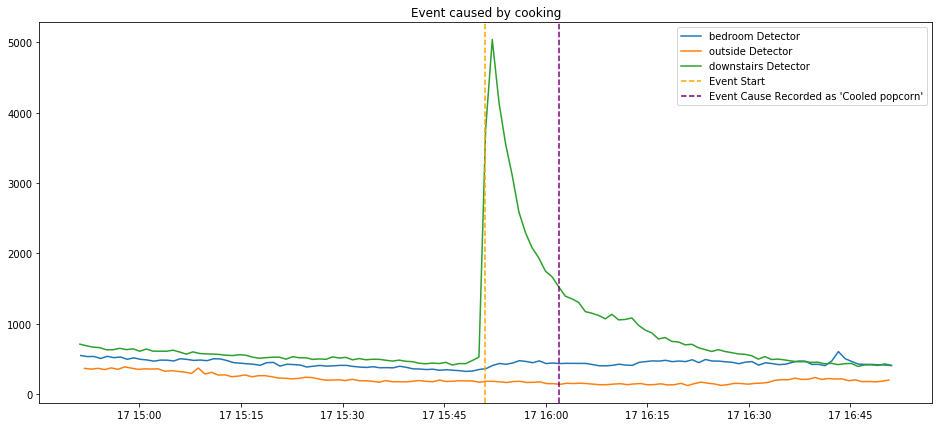

Family study ID, or deployment ID : [1070]
Event Name : ['Home (Arm 1: Family)']
Repeat Instrument : ['Eat Daily']
Repeat Instance : [154]
eat_pid : [869]
Time stamp daily eAT : ['8/17/2017 21:20']
Person filling this out (relationship to the patient) : ['self']
How would you rate your child's asthma control in the last 24 hours?  : [4]
How often did you/your child use an albuterol or Xopenex inhaler or receive a nebulized treatment in the last 24 hours? : [1]
In the last 24 hours, which of the following types of possible asthma triggers were you exposed to that affected (or could have affected) his/her asthma symptoms (check all that apply): Option Text - An environmental asthma trigger : [1.]
If this column = 1, that means user has selected one of the sub option for environmental triggers. Since user can selected multiple sub options, this information is stored in a different table called 'apt_triggers' : [1.]
In the last 24 hours, which of the following types of possible asthma trig

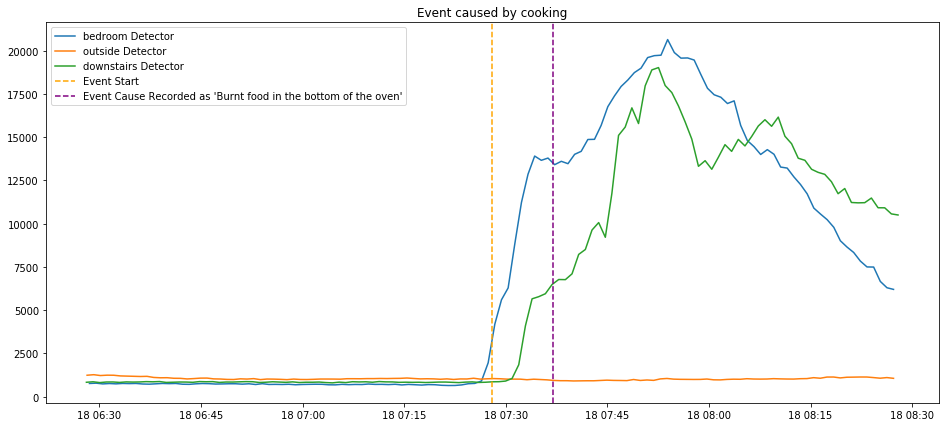

Family study ID, or deployment ID : [1070]
Event Name : ['Home (Arm 1: Family)']
Repeat Instrument : ['Eat Daily']
Repeat Instance : [155]
eat_pid : [869]
Time stamp daily eAT : ['8/18/2017 19:09']
Person filling this out (relationship to the patient) : ['self']
How would you rate your child's asthma control in the last 24 hours?  : [4]
How often did you/your child use an albuterol or Xopenex inhaler or receive a nebulized treatment in the last 24 hours? : [1]
In the last 24 hours, which of the following types of possible asthma triggers were you exposed to that affected (or could have affected) his/her asthma symptoms (check all that apply): Option Text - An environmental asthma trigger : [1.]
If this column = 1, that means user has selected one of the sub option for environmental triggers. Since user can selected multiple sub options, this information is stored in a different table called 'apt_triggers' : [1.]
In the last 24 hours, which of the following types of possible asthma trig

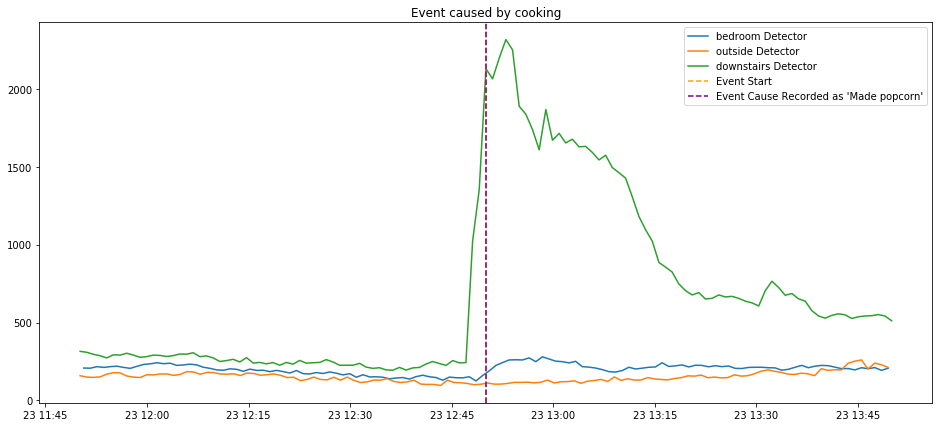

Family study ID, or deployment ID : [1070]
Event Name : ['Home (Arm 1: Family)']
Repeat Instrument : ['Eat Daily']
Repeat Instance : [160]
eat_pid : [869]
Time stamp daily eAT : ['8/23/2017 19:02']
Person filling this out (relationship to the patient) : ['self']
How would you rate your child's asthma control in the last 24 hours?  : [3]
How often did you/your child use an albuterol or Xopenex inhaler or receive a nebulized treatment in the last 24 hours? : [1]
In the last 24 hours, which of the following types of possible asthma triggers were you exposed to that affected (or could have affected) his/her asthma symptoms (check all that apply): Option Text - An environmental asthma trigger : [1.]
If this column = 1, that means user has selected one of the sub option for environmental triggers. Since user can selected multiple sub options, this information is stored in a different table called 'apt_triggers' : [1.]
In the last 24 hours, which of the following types of possible asthma trig

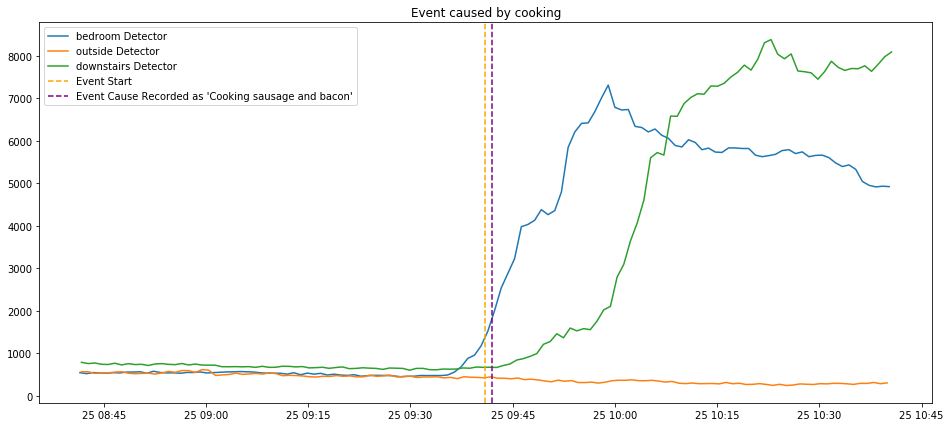

Family study ID, or deployment ID : [1070]
Event Name : ['Home (Arm 1: Family)']
Repeat Instrument : ['Eat Daily']
Repeat Instance : [162]
eat_pid : [869]
Time stamp daily eAT : ['8/25/2017 19:02']
Person filling this out (relationship to the patient) : ['self']
How would you rate your child's asthma control in the last 24 hours?  : [4]
How often did you/your child use an albuterol or Xopenex inhaler or receive a nebulized treatment in the last 24 hours? : [1]
In the last 24 hours, which of the following types of possible asthma triggers were you exposed to that affected (or could have affected) his/her asthma symptoms (check all that apply): Option Text - An environmental asthma trigger : [1.]
If this column = 1, that means user has selected one of the sub option for environmental triggers. Since user can selected multiple sub options, this information is stored in a different table called 'apt_triggers' : [1.]
In the last 24 hours, which of the following types of possible asthma trig

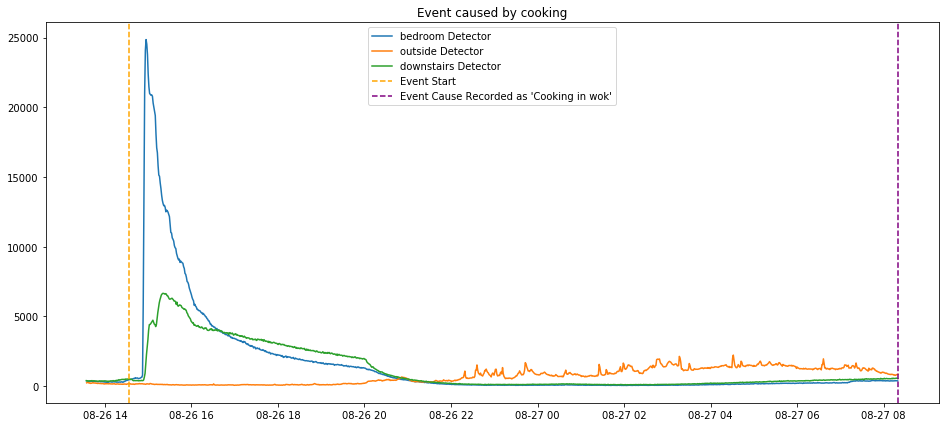

In [98]:
for spike_event in range(5):
    plotSpike(cooking_df, pm_df, daily_eat_df, spike_event)

# Aggregate Plots #

Text(0.5, 0, 'Date')

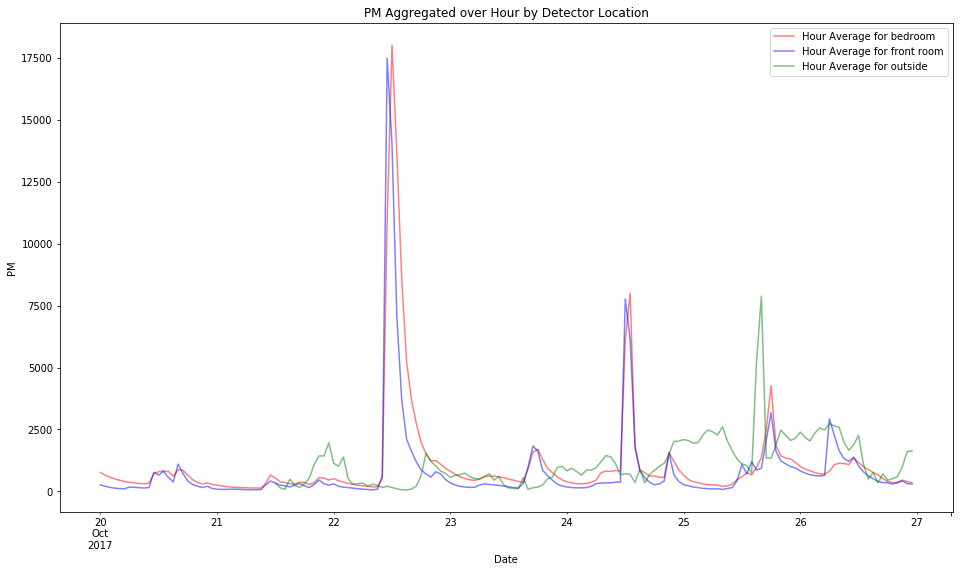

In [14]:
# Aggregate over hours #

# Pivot Table on Location #
loc_df = df.groupby([df.index.to_period('h'), 'location']).value.agg(['mean','max','min','std']).unstack(level=1)
  
# Plot Aggregate Data #
ax2 = loc_df['mean'].plot(figsize=(16,9), color=['Red','Blue','Green'], alpha=.5)
    # loc_df['mean'].plot(ax=ax2, color=['Red','Blue','Green'])
    
# Labels #
labels = [ 'Hour Average for {0}'.format(i) for i in list(loc_df['mean'].columns)]
ax2.legend(labels)

# Plot Info #
plt.title('PM Aggregated over Hour by Detector Location')
plt.ylabel('PM')
plt.xlabel('Date')

# Rolling Aggregates #

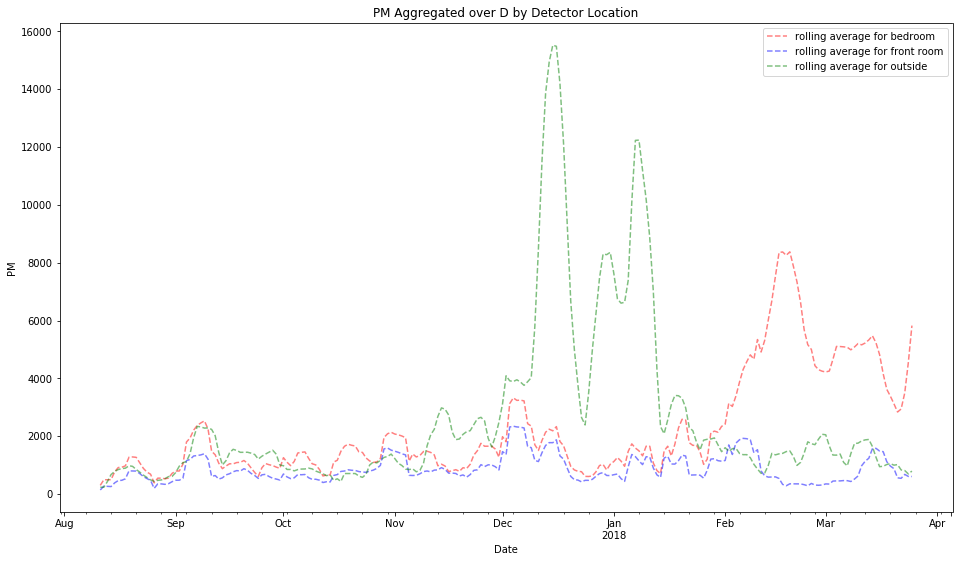

In [15]:
# one week rolling average over all data #
rollAQPlot(pm_df, 'D', 7)

# Average over time period#

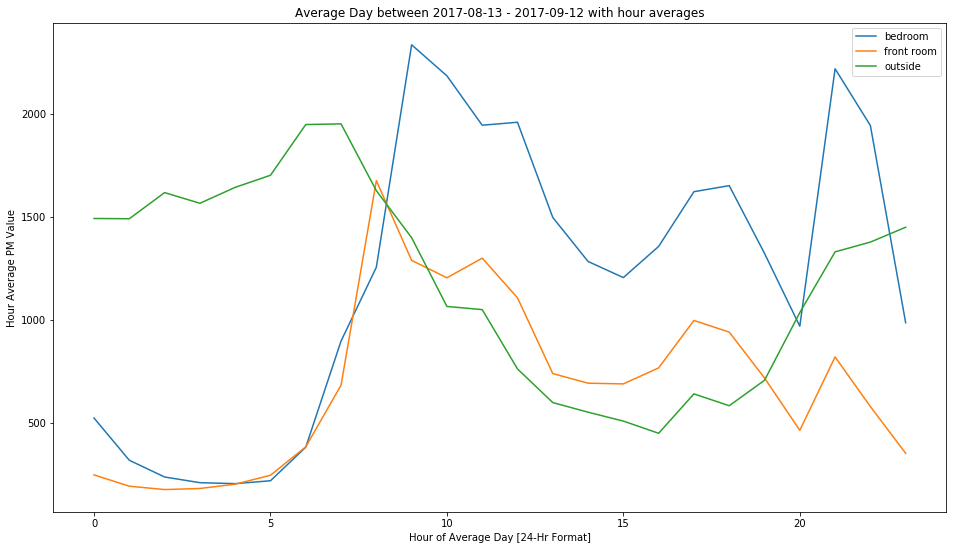

In [16]:
min_t, max_t = datetime.datetime(2017,8,13), datetime.datetime(2017,9,13)
    
df = pm_df[(pm_df.index > min_t) & (pm_df.index < max_t)]
hr_df = df.groupby(['hour','location']).value.agg(['mean','max','min','std']).unstack(level=1)
hr_df['mean'].plot(figsize=(16,9))
plt.title('Average Day between {0} - {1} with hour averages'.format(df.index.date.min(),df.index.date.max()))
plt.ylabel('Hour Average PM Value')
plt.xlabel('Hour of Average Day [24-Hr Format]')
plt.legend()

# Plot Hourly Average of Date Range over each other #

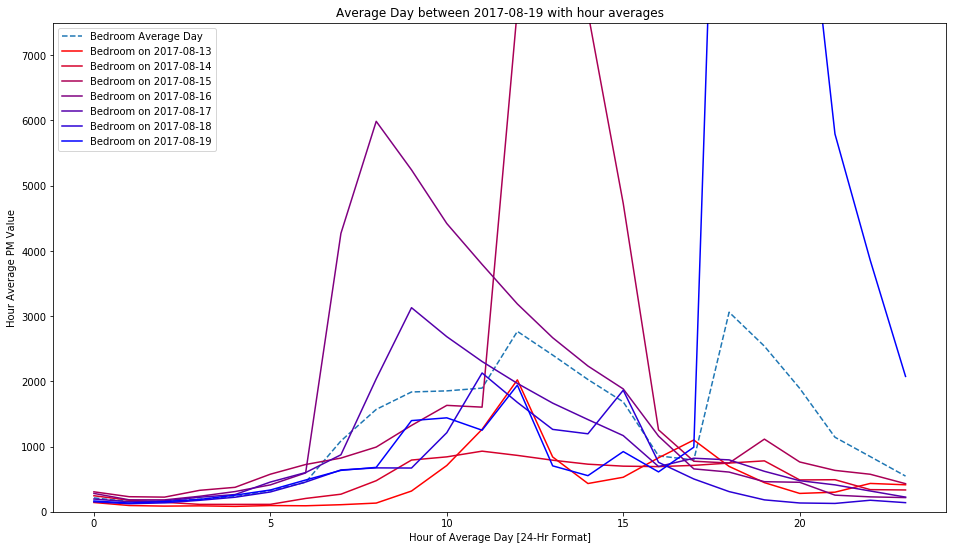

In [17]:
import pylab, matplotlib

# Average over time period#
min_t, max_t = datetime.datetime(2017,8,13), datetime.datetime(2017,8,20)
    
df = pm_df[(pm_df.index > min_t) & (pm_df.index < max_t)]
hr_df = df[df['location'] == 'bedroom'].groupby(['hour']).value.agg(['mean','max','min','std'])

# Plot Average and then all days #
fig = plt.figure(figsize=(16,9))

plt.plot(hr_df.index, hr_df['mean'], linestyle= '--', label='Bedroom Average Day')

# print((max_t-min_t).days)
n_days = (max_t-min_t).days 

# Day Color Range
mp = pylab.cm.datad['gist_rainbow']
get_color = matplotlib.colors.LinearSegmentedColormap.from_list(mp, colors=['r', 'b'], N=n_days)

#Plot Each Day Bedroom Hourly Average #
for day in range(n_days):
    
    # Define Day #
    i_day = datetime.datetime(2017,8,13) + datetime.timedelta(days=day)
    f_day = datetime.datetime(2017,8,13) + datetime.timedelta(days=day+1)
    
    # Select Day from DF #
    df = pm_df[(pm_df.index > i_day) & (pm_df.index < f_day)]
    
    # Hourly Average of Day #
    hr_df = df[df['location'] == 'bedroom'].groupby(['hour']).value.agg(['mean','max','min','std'])
    
    # Plot Day #
    plt.plot(hr_df.index, hr_df['mean'], color=get_color(day/n_days), label='Bedroom on {0}'.format(df.index.date.min()))

# Add Plot Information #
plt.title('Average Day between {0} with hour averages'.format(i_day.date()))
plt.ylabel('Hour Average PM Value')
plt.xlabel('Hour of Average Day [24-Hr Format]')
plt.ylim([0,7500])
plt.legend()  
plt.show()

# Plot 2 Dates over each other #

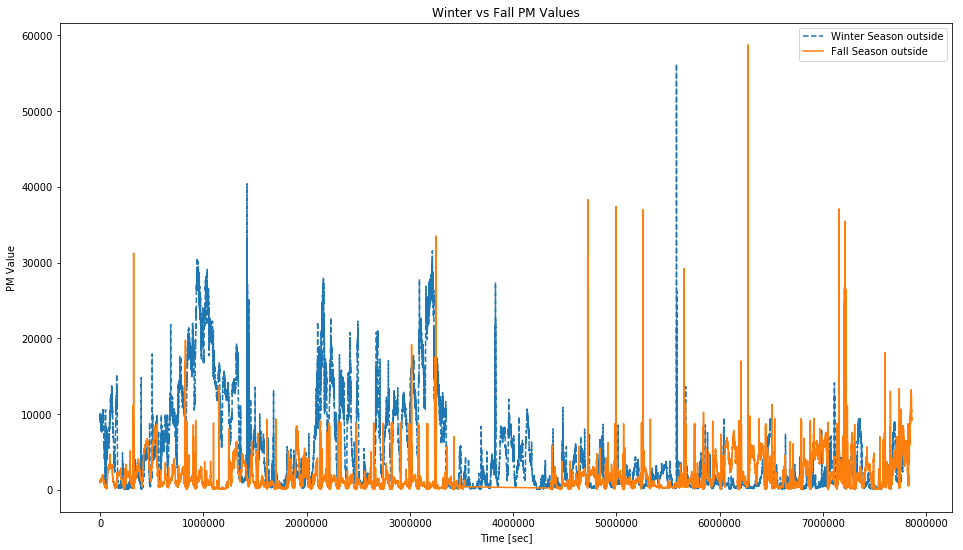

In [18]:
winter_df = pm_df[pm_df['season'] == 'winter']
fall_df = pm_df[pm_df['season'] == 'fall']

# print(winter_df.index)

fig = plt.figure(figsize=(16,9))
# print((winter_df.index - winter_df.index.min()).total_seconds())

# for location in df['location'].unique():
#     winter = winter_df[winter_df['location']== location]
#     fall = fall_df[fall_df['location']== location]
#     winter.index = (winter.index - winter.index.min()).total_seconds()
#     fall.index = (fall.index - fall.index.min()).total_seconds()
    
# #     display(fall)
#     winter['value'].plot( linestyle='--', label='Winter Season {0}'.format(location))
#     fall['value'].plot( linestyle='-', label='Fall Season {0}'.format(location))

winter = winter_df[winter_df['location']== 'outside']
fall = fall_df[fall_df['location']== 'outside']
winter.index = (winter.index - winter.index.min()).total_seconds()
fall.index = (fall.index - fall.index.min()).total_seconds()

winter['value'].plot( linestyle='--', label='Winter Season {0}'.format('outside'))
fall['value'].plot( linestyle='-', label='Fall Season {0}'.format('outside'))

# Add Plot Information #
plt.title('Winter vs Fall PM Values')
plt.ylabel('PM Value')
plt.xlabel('Time [sec]')
plt.legend()  
plt.show()
